In [360]:
import datajoint as dj
import pandas as pd
from pathlib import Path
from workflow import db_prefix
from workflow.pipeline import lab, event, session, subject, lab, trial, photometry
import workflow.utils.photometry_preprocessing as pp
from datajoint_utilities.dj_search.lists import drop_schemas
from datetime import datetime
import typing as T
import numpy as np
import warnings
warnings.filterwarnings('ignore')
dj.conn()
# dj.list_schemas()

DataJoint connection (disconnected) jaeronga@tutorial-db.datajoint.io:3306

In [304]:
# # Populate subject & session

mouse_id = "C40" 
experimenter = "john"
session_date = "20201106"  # "%m%d%y"
session_start_time = "103254"  # "%H%M%S"

# session_dir = Path(f"/home/jaerong/data/photometry/{mouse_id}_{session_date}")
# photo_dir = session_dir / f"{mouse_id}-{session_start_time}"

# # Insert subject and session info
# lab.User.insert1({"user": experimenter}, skip_duplicates=True)

# # Insert subject and session info
# subject.Subject.insert1(dict(subject=mouse_id, 
#                         sex='M', 
#                         subject_birth_date='2000-01-01', 
#                         subject_description=''), skip_duplicates=True)
# session_key = dict(subject=mouse_id, session_id=0, session_datetime=datetime.strptime(session_date + session_start_time, "%Y%m%d%H%M%S"))
# session.Session.insert1(session_key, skip_duplicates=True)
# session.SessionDirectory.insert1(dict(subject=session_key['subject'], session_id=session_key['session_id'], 
#                                       session_dir='C40_20201106'), skip_duplicates=True)

In [365]:
subject.Subject()

subject,sex,subject_birth_date,subject_description
C40,M,2000-01-01,


In [369]:
session.Session()
session.SessionDirectory()

subject,session_id,session_dir Path to the data directory for a session
C40,0,C40_20201106


In [89]:
# # Populate event, trial schema
# event.BehaviorIngestion.populate()

In [5]:
# # Populate Photometry schema
# photometry.FiberPhotometry.populate()

read from t=0s to t=1384.21s


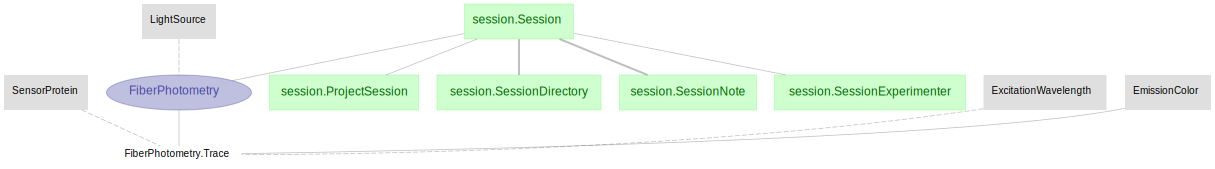

In [370]:
dj.Diagram(photometry) + dj.Diagram(session)

In [371]:
subject_key = (subject.Subject() & f"subject='{mouse_id}'").fetch("KEY")[0]
print(subject_key)

session_key = (session.Session() & f"subject='{mouse_id}'" & f"session_id=0").fetch("KEY")[0]
print(session_key)

{'subject': 'C40'}
{'subject': 'C40', 'session_id': 0}


In [372]:
photometry.FiberPhotometry() & session_key

subject,session_id,fiber_id,sample_rate (in Hz),"timestamps (in seconds) photometry timestamps, already synced to the master clock",light_source_name,time_offset (in second) time offset to synchronize the photometry traces to the master clock,notes
C40,0,1,50.0,=BLOB=,Plexon LED,67.94,
C40,0,2,50.0,=BLOB=,Plexon LED,67.94,


In [364]:
photometry.FiberPhotometry.Trace() & session_key

subject,session_id,fiber_id,"trace_name (e.g., raw, detrend, z)",emission_color,hemisphere,"sensor_protein_name (e.g., GCaMP, dLight, etc)",excitation_wavelength (nm),trace
C40,0,1,detrend,green,right,GCaMP,465,=BLOB=
C40,0,1,raw,green,right,GCaMP,465,=BLOB=
C40,0,1,z,green,right,GCaMP,465,=BLOB=
C40,0,2,detrend,green,left,GCaMP,465,=BLOB=
C40,0,2,raw,green,left,GCaMP,465,=BLOB=
C40,0,2,z,green,left,GCaMP,465,=BLOB=


In [321]:
subject.Implantation & subject_key

subject,implant_date surgery date,implant_type,brain_region,hemisphere,surgeon,ap (um) anterior-posterior; ref is 0,ap_ref,ml (um) medial axis; ref is 0,ml_ref,dv (um) dorso-ventral axis; ref is 0; more ventral is more negative,dv_ref,"theta (deg) rotation about the ml-axis [0, 180] - w.r.t the z+ axis","phi (deg) rotation about the dv-axis [0, 360] - w.r.t the x+ axis","beta (deg) rotation about the shank [-180, 180] - clockwise is increasing in degree - 0 is the probe-front facing anterior"
C40,2022-08-26,fiber,striatum,left,john,-3.110,bregma,-3.000,sagittal_suture,-2.500,dura,None,None,None
C40,2022-08-26,fiber,striatum,right,john,-3.110,bregma,-3.000,sagittal_suture,-2.500,dura,None,None,None


In [322]:
# Fetch one fiber 
fiber_id = 1
photometry.FiberPhotometry & session_key & f"fiber_id = '{fiber_id}'"

subject,session_id,fiber_id,sample_rate (in Hz),"timestamps (in seconds) photometry timestamps, already synced to the master clock",light_source_name,time_offset (in second) time offset to synchronize the photometry traces to the master clock,notes
C40,0,1,50.0,=BLOB=,Plexon LED,67.94,


In [323]:
# Fetch photometry timestamps
timestamps = (photometry.FiberPhotometry & session_key & f"fiber_id={fiber_id}").fetch1("timestamps")
timestamps

array([ 127.955,  127.975,  127.995, ..., 1187.155, 1187.175, 1187.18 ])

In [286]:
photometry.FiberPhotometry.Trace()
photometry.FiberPhotometry.Trace & session_key

subject,session_id,fiber_id,"trace_name (e.g., raw, detrend, z)",emission_color,hemisphere,"sensor_protein_name (e.g., GCaMP, dLight, etc)",excitation_wavelength (nm),trace
C40,0,1,detrend,green,right,GCaMP,465,=BLOB=
C40,0,1,raw,green,right,GCaMP,465,=BLOB=
C40,0,1,z,green,right,GCaMP,465,=BLOB=
C40,0,2,detrend,green,left,GCaMP,465,=BLOB=
C40,0,2,raw,green,left,GCaMP,465,=BLOB=
C40,0,2,z,green,left,GCaMP,465,=BLOB=


In [325]:
# Fetch photometry trace
trace_name = "detrend"
emission_color = "green"
hemisphere = "right"

restr = {
         "trace_name": trace_name, 
         "emission_color": emission_color,
         "hemisphere": hemisphere
         }
query = photometry.FiberPhotometry.Trace() & session_key & restr
trace = query.fetch1("trace")
query

subject,session_id,fiber_id,"trace_name (e.g., raw, detrend, z)",emission_color,hemisphere,"sensor_protein_name (e.g., GCaMP, dLight, etc)",excitation_wavelength (nm),trace
C40,0,1,detrend,green,right,GCaMP,465,=BLOB=


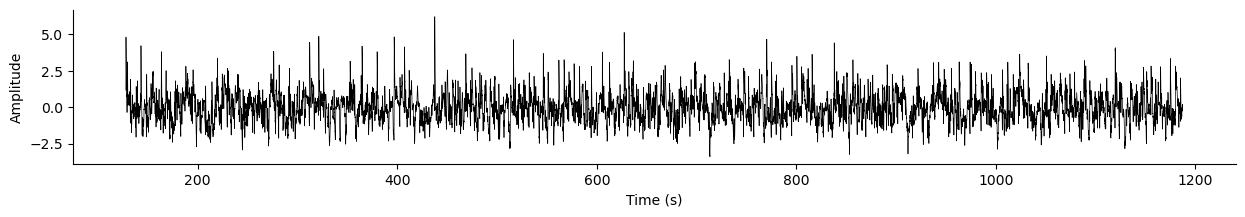

In [373]:
#Plot a single trace (detrend)
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import sem

fig, ax = plt.subplots(figsize=(15,2))

ax.plot(timestamps, trace, 'k', lw=0.5)
ax.set(xlabel='Time (s)', ylabel='Amplitude')
sns.despine()

[2022-09-23 10:52:16,028][WARNING]: MySQL server has gone away. Reconnecting to the server.


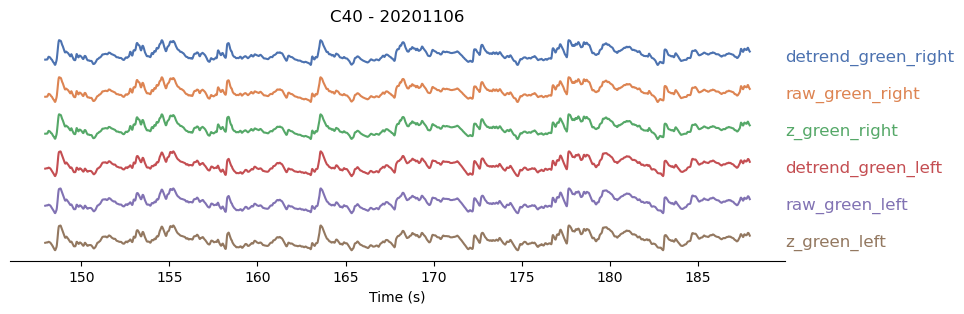

In [376]:
# Plot all phoeomtry traces during the session (replicate the figure)
query = photometry.FiberPhotometry.Trace & session_key

i= 8
inc_height= -1.5
window_start = 1000 
window_stop = 3000
fig, ax = plt.subplots(figsize=(10, 3))
sns.set_palette('deep',n_colors=len(query))

for j, trace in enumerate(photometry.FiberPhotometry.Trace.fetch("trace_name", "emission_color", "hemisphere", "trace", as_dict=True)):
    name = '_'.join([trace["trace_name"], trace["emission_color"], trace["hemisphere"]])
    ax.plot(timestamps[window_start:window_stop], 
            pp.normalize(pd.DataFrame(trace["trace"]), window=500)[window_start:window_stop] + i, 
            label=name); i += inc_height
    ax.text(x=timestamps[window_stop] + 2, 
            y=i-inc_height, s=name, fontsize=12, va="bottom", color=sns.color_palette()[j])
    
ax.set_title(f"{mouse_id} - {session_date}")
ax.set_xlabel("Time (s)")
ax.set_yticks([])
sns.despine(left=True)

### Event-related photometry traces

In [329]:
event.EventType & session_key

event_type,event_type_description
choice,
cue_end,
cue_start,
ENL_end,
ENL_start,
right_lick,


In [374]:
# Behavioral events during the session
event.Event & session_key

subject,session_id,event_type,event_start_time (second) relative to recording start,event_end_time (second) relative to recording start
C40,0,choice,2.575,nan
C40,0,choice,7.055,nan
C40,0,choice,12.485,nan
C40,0,choice,17.23,nan
C40,0,choice,22.51,nan
C40,0,choice,26.94,nan
C40,0,choice,31.41,nan
C40,0,choice,36.655,nan
C40,0,choice,41.08,nan
C40,0,choice,46.03,nan


In [379]:
event_types = (event.EventType & session_key).fetch("event_type")


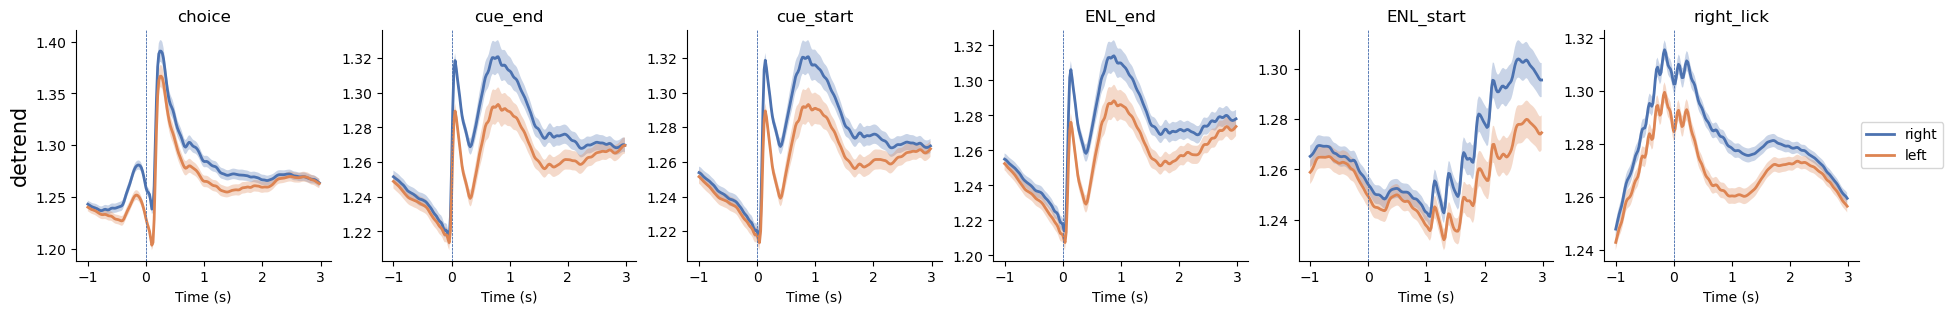

In [384]:
# Plot peri-event photometry traces per hemisphere
event_types = (event.EventType & session_key).fetch("event_type")
trace_name = "detrend"
emission_color = "green"

restr = {
         "trace_name": trace_name, 
         "emission_color": emission_color,
        #  "hemisphere": "right"
         }
query = photometry.FiberPhotometry.Trace() & session_key & restr
hemispheres, traces= query.fetch("hemisphere", "trace")

time_buffer = (1, 3)  # before and after each event 
sample_rate = photometry.FiberPhotometry.fetch("sample_rate")[0]
ts_interval = 1 / sample_rate
trace_ts = np.arange(-time_buffer[0], time_buffer[1], ts_interval)  # timestamps for the event trace

fig, axes = plt.subplots(1, len(event_types), figsize=(23, 3))
for ind, (event_type, ax) in enumerate(zip(event_types, axes)):

    for hemisphere, trace in zip(hemispheres, traces):

        df = pd.DataFrame({"timestamps": timestamps, "photometry_trace": trace})

        query = event.Event & session_key & f"event_type='{event_type}'"
        event_ts = query.fetch("event_start_time")

        start_ts = df["timestamps"].iloc[0]
        end_ts = df["timestamps"].iloc[-1]

        time_intervals = [(ts - time_buffer[0], ts + time_buffer[1]) for ts in list(event_ts)
                    if ts - time_buffer[0] > start_ts and  ts + time_buffer[1] < end_ts
                    ]

        peri_event_trace : T.List[np.ndarray] = []

        for interval in time_intervals:
            peri_event_trace.append(df[df["timestamps"].between(interval[0], interval[1], inclusive="left")]["photometry_trace"].values)
        
        peri_event_trace : np.ndarray = np.array(peri_event_trace) # trial x time
        ax.plot(trace_ts, np.mean(peri_event_trace, axis=0), label=hemisphere, lw=2)
        ax.fill_between(trace_ts, np.mean(peri_event_trace, axis=0) - sem(peri_event_trace, axis=0), 
                        np.mean(peri_event_trace, axis=0) + sem(peri_event_trace, axis=0) ,alpha=0.3)
        ax.axvline(x=0, linewidth=0.5, ls='--')
        if ind == 0: ax.set_ylabel(trace_name, fontsize=15)
        ax.set(xlabel='Time (s)', title=event_type)
        sns.despine()

plt.legend(loc='center left', bbox_to_anchor=(0.98, 0.5)) 
plt.show()

In [ ]:
# # Drop schemas in the order of dependencies
# photometry.schema.drop()

# from datajoint_utilities.dj_search.lists import drop_schemas
# drop_schemas(db_prefix, dry_run=False, force_drop=True)